# File structure

This project assumes the following initial file structure:

```
.\main                               
|   Preliminary data analysis.ipynb  
|   ...                              
|                                    
\---data                             
    \---olympic_sw_1896_2022         
            olympic_athletes.csv     
            olympic_hosts.csv        
            olympic_medals.csv       
            olympic_results.csv      
            olympic_results.pkl      
            ...                      
```

# Modules

## Imports

In [ ]:
import os
import types
from functools import partial

import geopandas as gpd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pkg_resources
import pycountry
from geopy.geocoders import Nominatim
from tqdm.notebook import tqdm

In [ ]:
tqdm.pandas()

## Versions

The current module versions in use are as follows:

In [ ]:
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        poorly_named_packages = {"PIL": "pillow", "sklearn": "scikit-learn"}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name


imports = list(set(get_imports()))

requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != "pip":
        requirements.append((m.project_name, m.version))

pd.DataFrame(requirements, columns=["Module", "Version"])

,Module,Version
0,geopandas,0.14.2
1,geopy,2.4.1
2,matplotlib,3.9.2
3,numpy,1.26.4
4,pandas,2.2.2
5,pycountry,24.6.1
6,tqdm,4.66.5


# Global variables

The following global variables are used throughout the entirety of the methodology section.

In [ ]:
DATA_PATH = "./data"
OLYMPIC_DATA_PATH = os.path.join(DATA_PATH, "olympic_sw_1896_2022")
CLEAN_DATA_PATH = os.path.join(DATA_PATH, "clean")

# Preliminary data analysis

In this section, we embark on a foundational exploration of our dataset to glean essential insights that underpin our research objectives. We outline the dataset's key attributes, including its size, composition, and structure, while examining descriptive statistics to uncover central tendencies and distributions.

## Data import

In [ ]:
athletes_data = pd.read_csv(os.path.join(OLYMPIC_DATA_PATH, "olympic_athletes.csv"))
medals_data = pd.read_csv(os.path.join(OLYMPIC_DATA_PATH, "olympic_medals.csv"))
hosts_data = pd.read_csv(os.path.join(OLYMPIC_DATA_PATH, "olympic_hosts.csv"))
results_data = pd.read_csv(os.path.join(OLYMPIC_DATA_PATH, "olympic_results.csv"))

## Athletes

In [ ]:
DROPPED_ATHLETES = 0

In [ ]:
athletes_data.sample(10)

,athlete_url,athlete_full_name,games_participations,first_game,athlete_year_birth,athlete_medals,bio
75205,https://olympics.com/en/athletes/james-thomas-...,James Thomas FIFER,2,Helsinki 1952,1930.0,\n\n\n1\n\nG\n\n,"\n\n\nIn 1952, Jim Fifer and Duvall Hecht rowe..."
57273,https://olympics.com/en/athletes/octavio-mobiglia,Octavio MOBIGLIA,2,Helsinki 1952,1923.0,NaN,NaN
75258,https://olympics.com/en/athletes/yrjo-jalmari-...,Yrjö Jalmari HIETANEN,2,Helsinki 1952,1927.0,\n\n\n2\n\nG\n\n,\n\n\nYrjö Hietanen was one of the best Finnis...
74020,https://olympics.com/en/athletes/sergey-shakray,Sergey SHAKRAY,1,Lake Placid 1980,1958.0,\n\n\n1\n\nS\n\n,\n\n\nSergey Shakhray and Marina Cherkasova ro...
9152,https://olympics.com/en/athletes/bastien-auzeil,Bastien AUZEIL,1,Rio 2016,1989.0,NaN,NaN
41995,https://olympics.com/en/athletes/abdullah-sali...,Abdullah Salim Saif AL-HUSSINI,1,Los Angeles 1984,1941.0,NaN,NaN
6946,https://olympics.com/en/athletes/anne-tauber,Anne TAUBER,1,Tokyo 2020,1995.0,NaN,NaN
51881,https://olympics.com/en/athletes/hubert-riesner,Hubert RIESNER,1,Mexico City 1968,1940.0,NaN,\n\n\nMarathon runner Hubert Riesner placed 33...
62884,https://olympics.com/en/athletes/jaroslav-skob...,Jaroslav SKOBLA,3,Paris 1924,1899.0,\n\n\n1\n\nG\n\n\n\n1\n\nB\n\n,"\n\n\nIn addition to his two Olympic medals, J..."
12001,https://olympics.com/en/athletes/james-guy,James GUY,2,Rio 2016,1995.0,\n\n\n2\n\nG\n\n\n\n3\n\nS\n\n,NaN


In [ ]:
athletes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75904 entries, 0 to 75903
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   athlete_url           75904 non-null  object 
 1   athlete_full_name     75904 non-null  object 
 2   games_participations  75904 non-null  int64  
 3   first_game            75882 non-null  object 
 4   athlete_year_birth    73448 non-null  float64
 5   athlete_medals        15352 non-null  object 
 6   bio                   22842 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 4.1+ MB


In [ ]:
athletes_data.describe(include=np.number)

,games_participations,athlete_year_birth
count,75904.000000,73448.000000
mean,1.535874,1961.619377
std,0.854563,28.129576
min,0.000000,1836.000000
25%,1.000000,1946.000000
50%,1.000000,1968.000000
75%,2.000000,1983.000000
max,10.000000,2009.000000


In [ ]:
athletes_data.describe(include=object)

,athlete_url,athlete_full_name,first_game,athlete_medals,bio
count,75904,75904,75882,15352,22842
unique,75900,75480,53,170,22530
top,https://olympics.com/en/athletes/mariana-pajon,Ivan IVANOV,Rio 2016,\n\n\n1\n\nB\n\n,\n\n\nPersonal Best: Mar – unknown.\n\n\n\n\n\n
freq,2,4,4111,4209,110


The following code converts the `athlete_year_birth` column to the `Int64` data type, which is a pandas-specific integer type that supports nullable values. This ensures that the column contains integer values while allowing for `NaN` entries, providing better consistency for numerical operations involving birth years.

In [ ]:
athletes_data["athlete_year_birth"] = athletes_data["athlete_year_birth"].astype("Int64")

The following code extracts information from the `first_game` column into two new columns, `first_game_host_city` and `first_game_year`, using a regular expression. The `.str.extract()` method is used with the regex pattern `r"^(.+?)\s(\d+?)$"` to capture the host city and the year separately. The pattern `^(.+?)\s(\d+?)$` matches the city name (which can contain spaces) followed by a space and a four-digit year, ensuring that both parts are properly captured. This allows us to split the `first_game` data into distinct columns for easier analysis.

In [ ]:
athletes_data[["first_game_city", "first_game_year"]] = athletes_data[
    "first_game"
].str.extract(r"^(.+?)\s(\d+?)$")

athletes_data["first_game_year"] = athletes_data["first_game_year"].astype("Int64")

The following code extracts medal information from the `athlete_medals` column, converts it into structured medal counts, and stores these in new columns. First, the regex `.str.findall()` is used to extract medal pairs (number and type) from each string into the `medal_tuples` column. Next, a helper function `count_medals()` is defined to count specific medal types (`G`, `S`, `B`) in each list of tuples. This function is applied to create `bronze_count`, `silver_count`, and `gold_count` columns, representing the count of each medal type. Finally, a `total_medals` column is created by calculating the sum of the three newly created columns.

In [ ]:
medal_tuples = athletes_data["athlete_medals"].str.findall(r"\n*(\d+)\n*([GSB])\n*")

In [ ]:
def count_medals(medal_list, medal_type):
    if not isinstance(medal_list, list):
        return 0
    return sum(int(count) for count, medal in medal_list if medal == medal_type)

In [ ]:
athletes_data["bronze_count"] = medal_tuples.apply(lambda x: count_medals(x, "B"))
athletes_data["silver_count"] = medal_tuples.apply(lambda x: count_medals(x, "S"))
athletes_data["gold_count"] = medal_tuples.apply(lambda x: count_medals(x, "G"))

athletes_data["total_medals"] = athletes_data[
    ["bronze_count", "silver_count", "gold_count"]
].sum(axis=1)

Here, we remove information that is redundant, or not pertinent for the present analysis.

In [ ]:
athletes_data = athletes_data.drop(["first_game", "bio", "athlete_medals"], axis=1)

We add some extra columns based on the location.

In [ ]:
geolocator = Nominatim(user_agent="city_to_country_mapper")
geocode = partial(geolocator.geocode, language="en")

city_country_cache = {}
country_code_cache_a2 = {}
country_code_cache_a3 = {}

country_code_cache_a3["Turkey"] = "TUR"
country_code_cache_a3["Chinese Taipei"] = "TWN"

def get_country(city):
    if pd.isna(city):
        return np.nan
    if city in city_country_cache:
        return city_country_cache[city]
    try:
        location = geocode(city)
        if location:
            country = location.address.split(",")[-1].strip()
            city_country_cache[city] = country
            return country
    except Exception as e:
        print(f"Error geocoding city '{city}': {e}")
    city_country_cache[city] = np.nan
    return np.nan


def get_country_code(country_name, alpha=2):
    if pd.isna(country_name):
        return np.nan
    cache = country_code_cache_a2 if alpha == 2 else country_code_cache_a3
    if country_name in cache:
        return cache[country_name]
    try:
        code = pycountry.countries.search_fuzzy(country_name)
        if code:
            iso_code = code[0].alpha_2 if alpha == 2 else code[0].alpha_3
            cache[country_name] = iso_code
            return iso_code
    except Exception as e:
        print(f"Error fetching country code for '{country_name}': {e}")
    cache[country_name] = np.nan
    return np.nan

In [ ]:
cities = pd.Series(athletes_data["first_game_city"].unique())
countries = cities.progress_apply(get_country)
country_codes_a2 = countries.map(lambda x: get_country_code(x, alpha=2))
country_codes_a3 = countries.map(lambda x: get_country_code(x, alpha=3))

city_to_country = dict(zip(cities, countries))
city_to_country_code_a2 = dict(zip(cities, country_codes_a2))
city_to_country_code_a3 = dict(zip(cities, country_codes_a3))

athletes_data.insert(
    athletes_data.columns.get_loc("first_game_city") + 1,
    "first_game_country",
    athletes_data["first_game_city"].map(city_to_country),
)
athletes_data.insert(
    athletes_data.columns.get_loc("first_game_city") + 2,
    "country_code",
    athletes_data["first_game_city"].map(city_to_country_code_a2),
)
athletes_data.insert(
    athletes_data.columns.get_loc("first_game_city") + 3,
    "country_3_letter_code",
    athletes_data["first_game_city"].map(city_to_country_code_a3),
)

  0%|          | 0/44 [00:00<?, ?it/s]

Finally, we visualize again, some preliminary informations of the entries of the resulting data frame.

In [ ]:
athletes_data.sample(10)

,athlete_url,athlete_full_name,games_participations,athlete_year_birth,first_game_city,first_game_country,country_code,country_3_letter_code,first_game_year,bronze_count,silver_count,gold_count,total_medals
41481,https://olympics.com/en/athletes/koji-sotomura,Koji SOTOMURA,1,1958,Los Angeles,United States,US,USA,1984,2,0,0,2
42387,https://olympics.com/en/athletes/richard-finch,Richard FINCH,1,<NA>,Los Angeles,United States,US,USA,1984,0,0,0,0
52725,https://olympics.com/en/athletes/nour-ullah-noor,Nour Ullah NOOR,1,<NA>,Tokyo,Japan,JP,JPN,1964,0,0,0,0
26078,https://olympics.com/en/athletes/garen-bloch,Garen BLOCH,1,1978,Sydney,Australia,AU,AUS,2000,0,0,0,0
70204,https://olympics.com/en/athletes/dorian-lance-...,Dorian Lance JAMES,2,1981,Athens,Greece,GR,GRC,2004,0,0,0,0
1381,https://olympics.com/en/athletes/belorukova,Yulia STUPAK,2,1995,PyeongChang,South Korea,KR,KOR,2018,3,0,1,4
35676,https://olympics.com/en/athletes/eric-magnin,Eric MAGNIN,1,1967,Barcelona,Spain,ES,ESP,1992,0,0,0,0
10162,https://olympics.com/en/athletes/cyril-tommasone,Cyril TOMMASONE,3,1987,London,United Kingdom,GB,GBR,2012,0,0,0,0
42842,https://olympics.com/en/athletes/gunter-schmieder,Günter SCHMIEDER,2,1957,Lake Placid,United States,US,USA,1980,0,0,0,0
60557,https://olympics.com/en/athletes/charles-james...,Charles James MORRIS,1,1915,London,United Kingdom,GB,GBR,1948,0,0,0,0


In [ ]:
athletes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75904 entries, 0 to 75903
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   athlete_url            75904 non-null  object
 1   athlete_full_name      75904 non-null  object
 2   games_participations   75904 non-null  int64 
 3   athlete_year_birth     73448 non-null  Int64 
 4   first_game_city        75882 non-null  object
 5   first_game_country     75882 non-null  object
 6   country_code           75882 non-null  object
 7   country_3_letter_code  75882 non-null  object
 8   first_game_year        75882 non-null  Int64 
 9   bronze_count           75904 non-null  int64 
 10  silver_count           75904 non-null  int64 
 11  gold_count             75904 non-null  int64 
 12  total_medals           75904 non-null  int64 
dtypes: Int64(2), int64(5), object(6)
memory usage: 7.7+ MB


In [ ]:
athletes_data.describe(include=np.number)

,games_participations,athlete_year_birth,first_game_year,bronze_count,silver_count,gold_count,total_medals
count,75904.000000,73448.0,75882.0,75904.000000,75904.000000,75904.000000,75904.000000
mean,1.535874,1961.619377,1984.765742,0.109889,0.105844,0.109994,0.325727
std,0.854563,28.129576,28.683834,0.369809,0.380472,0.458560,0.851044
min,0.000000,1836.0,1896.0,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1946.0,1968.0,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1968.0,1992.0,0.000000,0.000000,0.000000,0.000000
75%,2.000000,1983.0,2008.0,0.000000,0.000000,0.000000,0.000000
max,10.000000,2009.0,2022.0,6.000000,6.000000,23.000000,28.000000


In [ ]:
athletes_data.describe(include=object)

,athlete_url,athlete_full_name,first_game_city,first_game_country,country_code,country_3_letter_code
count,75904,75904,75882,75882,75882,75882
unique,75900,75480,43,23,23,23
top,https://olympics.com/en/athletes/mariana-pajon,Ivan IVANOV,London,United States,US,USA
freq,2,4,6113,9812,9812,9812


#### Inconsistencies

The following code drops rows with athletes who have no games_participations.

In [ ]:
DROPPED_ATHLETES += np.sum(athletes_data["games_participations"] == 0)

print(f"Total athletes dropped: {DROPPED_ATHLETES}")

Total athletes dropped: 22


In [ ]:
athletes_data = athletes_data[athletes_data["games_participations"] != 0]

Now, let's first take a look at the time stamps of the olympics as compared to athletes' ages.

In [ ]:
game_years = pd.Series(
    pd.unique(athletes_data["first_game_year"].dropna())
).sort_values(ascending=True)

box_data_birth = []
box_data_age = []
for game_year in game_years:
    year_births = athletes_data[athletes_data["first_game_year"] == game_year][
        "athlete_year_birth"
    ].dropna()

    box_data_birth.append(year_births)
    box_data_age.append(game_year - year_births)

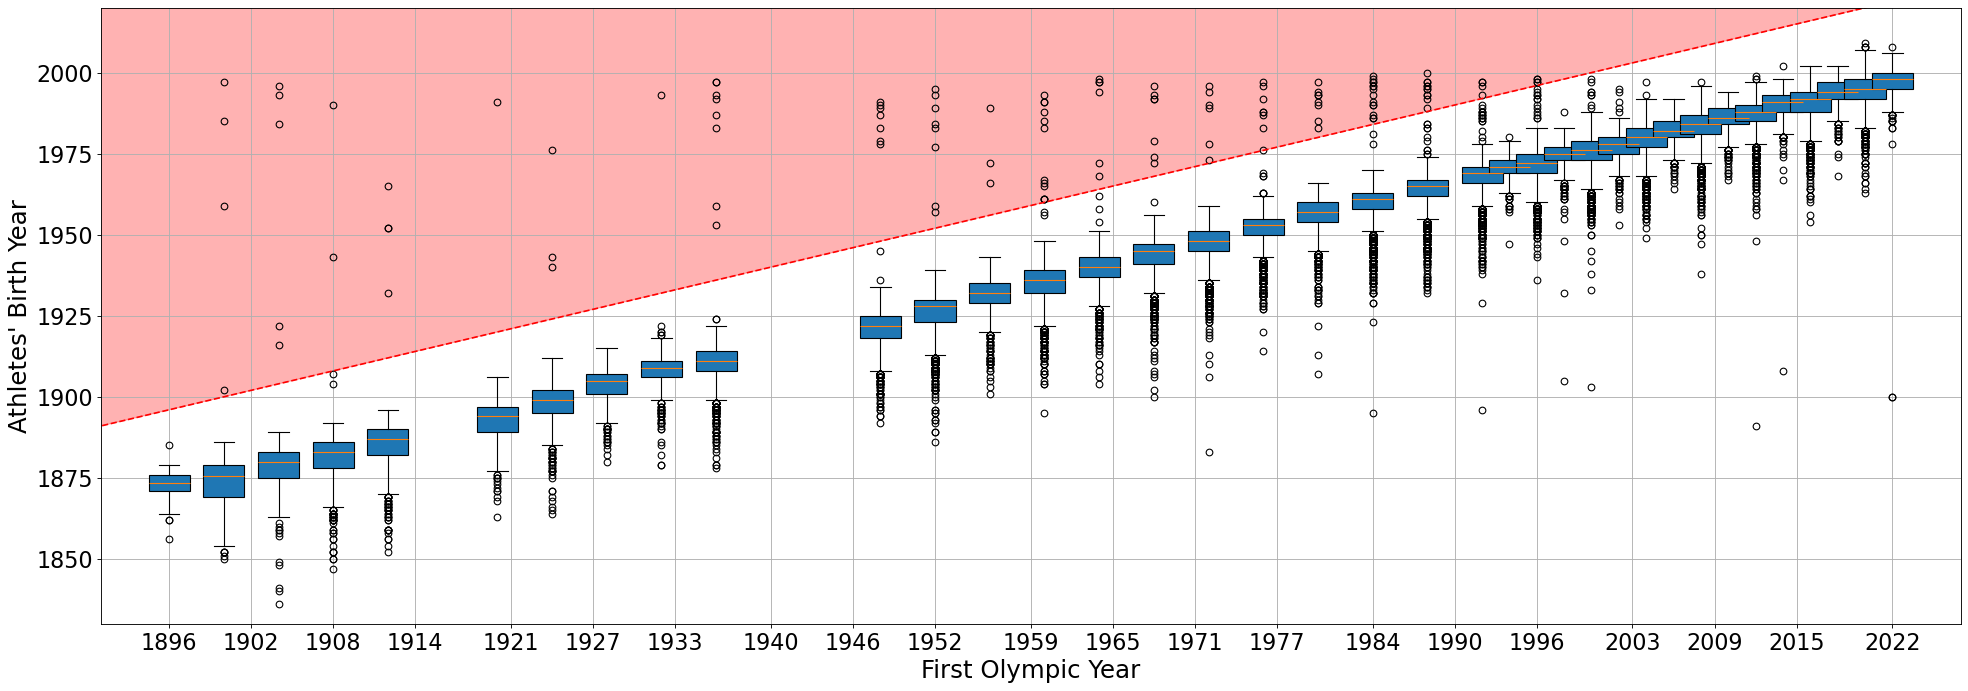

In [ ]:
plt.figure(figsize=(30, 10), dpi=80)

plt.boxplot(
    box_data_birth,
    positions=game_years,
    widths=[3] * len(game_years),
    patch_artist=True,
    manage_ticks=False,
)

line_data = np.arange(min(game_years) / 1.1, 1.1 * max(game_years))
plt.plot(line_data, line_data, linestyle="--", c="red")
plt.fill_between(x=line_data, y1=line_data, y2=2040, alpha=0.3, color="red")

# Decoration
# plt.title(
#     "Distribution of Athletes' Birth Years by First Olympic Appearance", fontsize=22
# )
plt.xlabel("First Olympic Year", fontsize=22)
plt.xticks(
    ticks=np.linspace(min(game_years), max(game_years), num=21, dtype=int),
    # rotation=45,
    fontsize=20,
)
plt.xlim(min(game_years) - 5, max(game_years) + 5)
plt.yticks(fontsize=20)
plt.ylabel("Athletes' Birth Year", fontsize=22)
plt.ylim(1830, 2020)
plt.grid()
plt.show()

In [ ]:
# References:
# https://eu.usatoday.com/story/sports/olympics/2022/11/24/who-is-youngest-olympian/10380713002/
# https://www.oldest.org/sports/olympians/
youngestOlympian = 10
oldestOlympian = 73

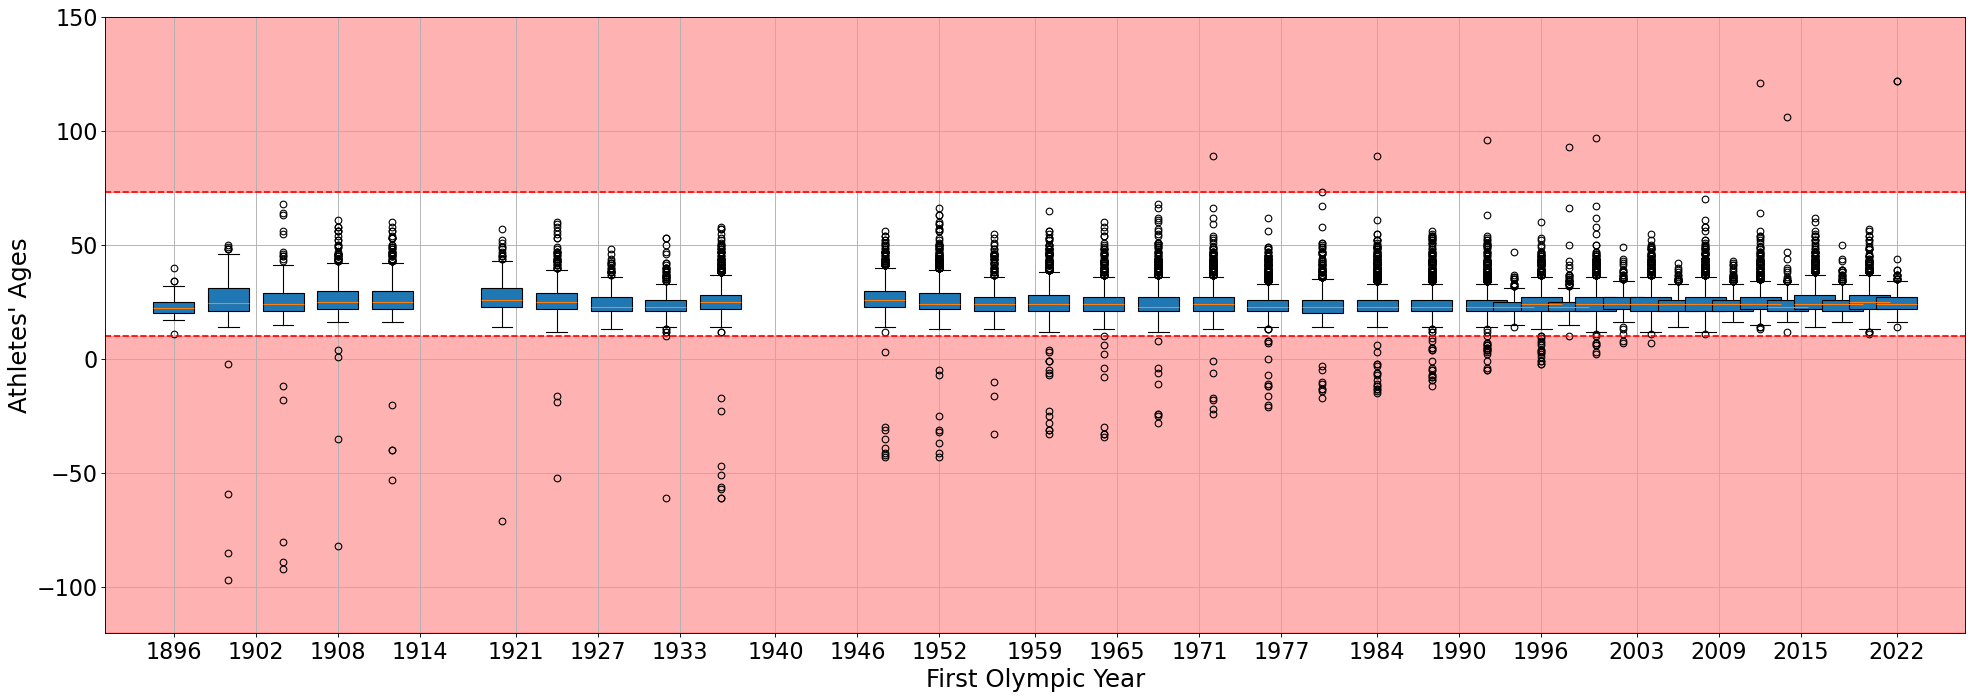

In [ ]:
plt.figure(figsize=(30, 10), dpi=80)


plt.boxplot(
    box_data_age,
    positions=game_years,
    widths=[3] * len(game_years),
    patch_artist=True,
    manage_ticks=False,
)

line_data = np.arange(min(game_years) / 2, 2 * max(game_years))
plt.axhline(youngestOlympian, linestyle="--", c="red")
plt.fill_between(x=line_data, y1=youngestOlympian, y2=-120, alpha=0.3, color="red")

plt.axhline(oldestOlympian, linestyle="--", c="red")
plt.fill_between(x=line_data, y1=oldestOlympian, y2=150, alpha=0.3, color="red")

# Decoration
# plt.title("Distribution of Athletes' Ages at Their First Olympic Appearance", fontsize=22)
plt.xlabel("First Olympic Year", fontsize=22)
plt.xticks(
    ticks=np.linspace(min(game_years), max(game_years), num=21, dtype=int),
    # rotation=45,
    fontsize=20,
)
plt.xlim(min(game_years) - 5, max(game_years) + 5)
plt.yticks(fontsize=20)
plt.ylabel("Athletes' Ages", fontsize=22)
plt.ylim(-120, 150)
plt.grid()
plt.show()

In [ ]:
ageAtFirstOlympiad = (
    athletes_data["first_game_year"] - athletes_data["athlete_year_birth"]
)
tooYoungOldOlympic = (ageAtFirstOlympiad < youngestOlympian) | (
    oldestOlympian < ageAtFirstOlympiad
)

In [ ]:
print(f"We discovered at least {np.sum(tooYoungOldOlympic)} inconsistencies!")

We discovered at least 186 inconsistencies!


We remove the inconsistent data:

In [ ]:
DROPPED_ATHLETES += np.sum(tooYoungOldOlympic)

print(f"Total athletes dropped: {DROPPED_ATHLETES}")

Total athletes dropped: 208


In [ ]:
athletes_data = athletes_data.drop(athletes_data[tooYoungOldOlympic].index)

Let's now look at the athletes' names.

In [ ]:
athletes_data["athlete_full_name"].sort_values()[:10]

9840                    DENI DENI
5312                       . DENI
6257                   . PRIYANKA
6502                      . RAHUL
31310              A Baser WASIQI
1265                     A J HURT
31995        A-Aziz Hassan JALOOF
67749                   A. DARNIS
64387         A. Germaine GOLDING
69797    A. Linger ANDREAS LINGER
Name: athlete_full_name, dtype: object

In our data, there are names which were abbreviated and names which start with uncommon characters such as spaces. We, thus, clean our data by: removing leading/trailing spaces, removing rows starting with a period

In [ ]:
athletes_data["athlete_full_name"] = (
    athletes_data["athlete_full_name"]
    .str.replace(r"\s*\.\s*", "", regex=True)
    .str.strip()
    .str.upper()
)

In [ ]:
countsDict = athletes_data["athlete_full_name"].value_counts().to_dict()

athletes_data["name_frequency"] = athletes_data.apply(lambda x: countsDict[x["athlete_full_name"]], axis=1)

athletes_data[athletes_data["name_frequency"] > 1].sort_values(
    by=["name_frequency", "athlete_full_name"], ascending=[False, True]
).head(10)

,athlete_url,athlete_full_name,games_participations,athlete_year_birth,first_game_city,first_game_country,country_code,country_3_letter_code,first_game_year,bronze_count,silver_count,gold_count,total_medals,name_frequency
28156,https://olympics.com/en/athletes/francisco-san...,FRANCISCO SANCHEZ,2,1976,Atlanta,United States,US,USA,1996,0,0,0,0,4
44334,https://olympics.com/en/athletes/francisco-san...,FRANCISCO SANCHEZ,1,1958,Moscow,Russia,RU,RUS,1980,0,0,0,0,4
47128,https://olympics.com/en/athletes/francisco-san...,FRANCISCO SANCHEZ,1,1956,Montreal,Canada,CA,CAN,1976,0,0,0,0,4
72475,https://olympics.com/en/athletes/francisco-san...,FRANCISCO SANCHEZ,3,1965,Seoul,South Korea,KR,KOR,1988,0,0,1,1,4
15863,https://olympics.com/en/athletes/hao-wang-5,HAO WANG,3,1983,Athens,Greece,GR,GRC,2004,0,3,2,5,4
18819,https://olympics.com/en/athletes/hao-wang-4,HAO WANG,1,1989,Beijing,China,CN,CHN,2008,0,0,0,0,4
40755,https://olympics.com/en/athletes/hao-wang-3,HAO WANG,1,1962,Los Angeles,United States,US,USA,1984,0,0,0,0,4
69809,https://olympics.com/en/athletes/hao-wang-2,HAO WANG,1,1992,London,United Kingdom,GB,GBR,2012,0,0,1,1,4
12242,https://olympics.com/en/athletes/ivan-ivanov-8,IVAN IVANOV,1,1989,Rio,Brazil,BR,BRA,2016,0,0,0,0,4
18714,https://olympics.com/en/athletes/ivan-ivanov,IVAN IVANOV,1,1986,Beijing,China,CN,CHN,2008,0,0,0,0,4


In [ ]:
print(
    f"We discovered {len(athletes_data[athletes_data["name_frequency"] > 1]["athlete_full_name"].unique())} with repeated rows"
)
print(f"We discovered at least {len(athletes_data[athletes_data["name_frequency"] > 1])} inconsistencies!")

We discovered 374 with repeated rows
We discovered at least 795 inconsistencies!


We drop the rows with duplicate names, retaining only the first occurrence of each unique name.

In [ ]:
DROPPED_ATHLETES += len(athletes_data[athletes_data["name_frequency"] > 1]) - len(
    athletes_data[athletes_data["name_frequency"] > 1]["athlete_full_name"].unique()
)

print(f"Total athletes dropped: {DROPPED_ATHLETES}")

Total athletes dropped: 629


In [ ]:
athletes_data = athletes_data.drop_duplicates(
    subset=["athlete_full_name"], keep="first"
)

athletes_data = athletes_data.drop("name_frequency", axis=1)

Let's finally take a look at athlete's URL's.

In [ ]:
print(f"Total number of entries: {len(athletes_data)}")
print(f"Number of unique names: {len(athletes_data["athlete_full_name"].unique())}")
print(f"Number of unique URLs: {len(athletes_data["athlete_url"].unique())}")
print(
    f"Difference: {len(athletes_data["athlete_full_name"].unique()) - len(athletes_data["athlete_url"].unique())}"
)

Total number of entries: 75275
Number of unique names: 75275
Number of unique URLs: 75272
Difference: 3


We drop the rows with duplicate athlete URL, retaining only the first occurrence of each unique URL.

In [ ]:
DROPPED_ATHLETES += len(athletes_data["athlete_full_name"].unique()) - len(
    athletes_data["athlete_url"].unique()
)

print(f"Total athletes dropped: {DROPPED_ATHLETES}")

Total athletes dropped: 632


In [ ]:
athletes_data = athletes_data.drop_duplicates(subset=["athlete_url"], keep="first")

Finally, we save our cleaned data.

In [ ]:
athletes_data = athletes_data.reset_index(drop=True)

In [ ]:
athletes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75272 entries, 0 to 75271
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   athlete_url            75272 non-null  object
 1   athlete_full_name      75272 non-null  object
 2   games_participations   75272 non-null  int64 
 3   athlete_year_birth     72821 non-null  Int64 
 4   first_game_city        75272 non-null  object
 5   first_game_country     75272 non-null  object
 6   country_code           75272 non-null  object
 7   country_3_letter_code  75272 non-null  object
 8   first_game_year        75272 non-null  Int64 
 9   bronze_count           75272 non-null  int64 
 10  silver_count           75272 non-null  int64 
 11  gold_count             75272 non-null  int64 
 12  total_medals           75272 non-null  int64 
dtypes: Int64(2), int64(5), object(6)
memory usage: 7.6+ MB


In [ ]:
athletes_data.to_csv(os.path.join(CLEAN_DATA_PATH, "olympic_athletes.csv"), index=False)

## Medals

In [ ]:
medals_data.sample(10)

,discipline_title,slug_game,event_title,event_gender,medal_type,participant_type,participant_title,athlete_url,athlete_full_name,country_name,country_code,country_3_letter_code
9792,Athletics,barcelona-1992,5000m men,Men,GOLD,Athlete,NaN,https://olympics.com/en/athletes/dieter-baumann,Dieter BAUMANN,Germany,DE,GER
12534,Gymnastics Artistic,moscow-1980,parallel bars men,Men,SILVER,Athlete,NaN,https://olympics.com/en/athletes/aleksandr-dit...,Aleksandr DITYATIN,Soviet Union,NaN,URS
9931,Baseball,barcelona-1992,baseball men,Men,BRONZE,GameTeam,Japan team,NaN,NaN,Japan,JP,JPN
21303,Cycling Track,paris-1900,Sprint individual men,Men,GOLD,Athlete,NaN,NaN,Albert Taillandier,France,FR,FRA
19280,Boxing,amsterdam-1928,7938kg heavyweight men,Men,SILVER,Athlete,NaN,https://olympics.com/en/athletes/nils-arvid-ramm,Nils Arvid RAMM,Sweden,SE,SWE
16646,Modern Pentathlon,melbourne-1956,Individual competition men,Men,GOLD,Athlete,NaN,https://olympics.com/en/athletes/lars-hall,Lars HALL,Sweden,SE,SWE
13923,Speed skating,innsbruck-1976,500m men,Men,GOLD,Athlete,NaN,https://olympics.com/en/athletes/yevgeny-kulikov,Yevgeny KULIKOV,Soviet Union,NaN,URS
13887,Figure skating,innsbruck-1976,Pairs mixed,Mixed,GOLD,GameTeam,Soviet Union team #1,https://olympics.com/en/athletes/irina-rodnina,Irina RODNINA,Soviet Union,NaN,URS
1569,Speed skating,pyeongchang-2018,Men’s 1500m,Men,BRONZE,Athlete,NaN,https://olympics.com/en/athletes/kim-16,Min Seok KIM,Republic of Korea,KR,KOR
18325,Fencing,berlin-1936,foil individual men,Men,BRONZE,Athlete,NaN,https://olympics.com/en/athletes/giorgio-bocchino,Giorgio BOCCHINO,Italy,IT,ITA


In [ ]:
medals_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21697 entries, 0 to 21696
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   discipline_title       21697 non-null  object
 1   slug_game              21697 non-null  object
 2   event_title            21697 non-null  object
 3   event_gender           21697 non-null  object
 4   medal_type             21697 non-null  object
 5   participant_type       21697 non-null  object
 6   participant_title      6584 non-null   object
 7   athlete_url            17027 non-null  object
 8   athlete_full_name      18073 non-null  object
 9   country_name           21697 non-null  object
 10  country_code           20195 non-null  object
 11  country_3_letter_code  21697 non-null  object
dtypes: object(12)
memory usage: 2.0+ MB


In [ ]:
medals_data.describe(include=object)

,discipline_title,slug_game,event_title,event_gender,medal_type,participant_type,participant_title,athlete_url,athlete_full_name,country_name,country_code,country_3_letter_code
count,21697,21697,21697,21697,21697,21697,6584,17027,18073,21697,20195,21697
unique,86,53,1436,4,3,2,493,12116,12895,154,143,154
top,Athletics,tokyo-2020,Individual men,Men,BRONZE,Athlete,United States team,https://olympics.com/en/athletes/michael-phelp...,Michael PHELPS,United States of America,US,USA
freq,3080,1188,215,13932,7529,15113,523,16,16,3094,3094,3094


We noticed that some athletes in this dataset lack corresponding metadata in `athletes_data`.

In [ ]:
athlete_urls_set = set(athletes_data["athlete_url"].dropna())
medals_urls_set = set(medals_data["athlete_url"].dropna())

missing_urls = list(medals_urls_set - athlete_urls_set)

print(f"There are {len(missing_urls)} medalists without metadata")

There are 115 medalists without metadata


We noticed that not all athletes have an associated URL.

In [ ]:
np.sum(~medals_data["athlete_full_name"].isna()) == np.sum(~medals_data["athlete_url"].isna())

False

In [ ]:
print(
    f"Athletes without URL: {np.sum(~medals_data["athlete_full_name"].isna() & medals_data["athlete_url"].isna())}"
)

Athletes without URL: 1046


We observed that individual competitions do not have a group title, which is logical given their nature, whereas group competitions are appropriately assigned a group title.

In [ ]:
len(medals_data[medals_data["participant_type"] == "Athlete"]) == np.sum(medals_data["participant_title"].isna())

True

In [ ]:
len(medals_data[medals_data["participant_type"] == "GameTeam"]) == np.sum(~medals_data["participant_title"].isna())

True

However, we discovered that some group competitions included an athlete's full name, presumably of an individual who participated in the competition. Since no documentation regarding these entries was found, this interpretation remains speculative.

In [ ]:
len(medals_data[medals_data["participant_type"] == "GameTeam"]) == np.sum(medals_data["athlete_full_name"].isna())

False

In [ ]:
group_competitions = medals_data[medals_data["participant_type"] == "GameTeam"]
group_with_full_name = group_competitions[
    ~group_competitions["athlete_full_name"].isna()
]

group_with_full_name.head()

,discipline_title,slug_game,event_title,event_gender,medal_type,participant_type,participant_title,athlete_url,athlete_full_name,country_name,country_code,country_3_letter_code
0,Curling,beijing-2022,Mixed Doubles,Mixed,GOLD,GameTeam,Italy,https://olympics.com/en/athletes/stefania-cons...,Stefania CONSTANTINI,Italy,IT,ITA
1,Curling,beijing-2022,Mixed Doubles,Mixed,GOLD,GameTeam,Italy,https://olympics.com/en/athletes/amos-mosaner,Amos MOSANER,Italy,IT,ITA
2,Curling,beijing-2022,Mixed Doubles,Mixed,SILVER,GameTeam,Norway,https://olympics.com/en/athletes/kristin-skaslien,Kristin SKASLIEN,Norway,NO,NOR
3,Curling,beijing-2022,Mixed Doubles,Mixed,SILVER,GameTeam,Norway,https://olympics.com/en/athletes/magnus-nedreg...,Magnus NEDREGOTTEN,Norway,NO,NOR
4,Curling,beijing-2022,Mixed Doubles,Mixed,BRONZE,GameTeam,Sweden,https://olympics.com/en/athletes/almida-de-val,Almida DE VAL,Sweden,SE,SWE


In [ ]:
print(f"Number of group competitions: {len(group_competitions)}")
print(f"Number of group competitions with full name: {len(group_with_full_name)}")
print(f"Number of group competitions without full name: {len(group_competitions) - len(group_with_full_name)}")

Number of group competitions: 6584
Number of group competitions with full name: 2960
Number of group competitions without full name: 3624


Up until now, despite encountering some unusual occurrences, we have chosen not to remove the rows containing them.

We noticed some countries missing their countries codes:

In [ ]:
print(medals_data[medals_data["country_code"].isna()]["country_name"].unique())

['Namibia' 'Olympic Athletes from Russia' 'Trinidad and Tobago'
 'Unified Team' 'Soviet Union' 'Lebanon' 'West Indies Federation'
 'United Arab Republic' 'Australasia' 'Bohemia' 'MIX']


In [ ]:
medals_data["country_code"] = medals_data.apply(
    lambda row: (
        get_country_code(row["country_name"])
        if pd.isna(row["country_code"])
        and row["country_name"] in ["Namibia", "Trinidad and Tobago", "Lebanon"]
        else row["country_code"]
    ),
    axis=1,
)

We have noticed that some of the rows of `country_3_letter_code` did not correspond to the actual country code. Thus, we repopulate this column:

In [ ]:
medals_data["country_3_letter_code"] = medals_data["country_name"].map(lambda x: get_country_code(x, alpha=3))

Error fetching country code for 'Hong Kong, China': hong kong, china
Error fetching country code for 'Olympic Athletes from Russia': olympic athletes from russia
Error fetching country code for 'Independent Olympic Athletes': independent olympic athletes
Error fetching country code for 'Serbia and Montenegro': serbia and montenegro
Error fetching country code for 'Unified Team': unified team
Error fetching country code for 'Czechoslovakia': czechoslovakia
Error fetching country code for 'Soviet Union': soviet union
Error fetching country code for 'German Democratic Republic (Germany)': german democratic republic (germany)
Error fetching country code for 'Yugoslavia': yugoslavia
Error fetching country code for 'Netherlands Antilles': netherlands antilles
Error fetching country code for 'Virgin Islands, US': virgin islands, us
Error fetching country code for 'West Indies Federation': west indies federation
Error fetching country code for 'United Arab Republic': united arab republic
Error

Finally, we save our cleaned data.

In [ ]:
medals_data = medals_data.reset_index(drop=True)

In [ ]:
athletes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75272 entries, 0 to 75271
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   athlete_url            75272 non-null  object
 1   athlete_full_name      75272 non-null  object
 2   games_participations   75272 non-null  int64 
 3   athlete_year_birth     72821 non-null  Int64 
 4   first_game_city        75272 non-null  object
 5   first_game_country     75272 non-null  object
 6   country_code           75272 non-null  object
 7   country_3_letter_code  75272 non-null  object
 8   first_game_year        75272 non-null  Int64 
 9   bronze_count           75272 non-null  int64 
 10  silver_count           75272 non-null  int64 
 11  gold_count             75272 non-null  int64 
 12  total_medals           75272 non-null  int64 
dtypes: Int64(2), int64(5), object(6)
memory usage: 7.6+ MB


In [ ]:
medals_data.to_csv(os.path.join(CLEAN_DATA_PATH, "olympic_medals.csv"), index=False)

## Hosts

In [ ]:
hosts_data.sample(10)

,game_slug,game_end_date,game_start_date,game_location,game_name,game_season,game_year
36,oslo-1952,1952-02-25T19:00:00Z,1952-02-14T07:00:00Z,Norway,Oslo 1952,Winter,1952
12,nagano-1998,1998-02-22T11:00:00Z,1998-02-06T23:00:00Z,Japan,Nagano 1998,Winter,1998
38,st-moritz-1948,1948-02-08T19:00:00Z,1948-01-30T07:00:00Z,Switzerland,St. Moritz 1948,Winter,1948
42,lake-placid-1932,1932-02-15T18:00:00Z,1932-02-04T13:00:00Z,United States,Lake Placid 1932,Winter,1932
17,seoul-1988,1988-10-02T10:00:00Z,1988-09-16T22:00:00Z,Republic of Korea,Seoul 1988,Summer,1988
11,sydney-2000,2000-10-01T09:00:00Z,2000-09-15T01:00:00Z,Australia,Sydney 2000,Summer,2000
39,berlin-1936,1936-08-16T19:00:00Z,1936-08-01T07:00:00Z,Germany,Berlin 1936,Summer,1936
50,st-louis-1904,1904-11-24T02:00:00Z,1904-07-01T14:00:00Z,United States,St. Louis 1904,Summer,1904
0,beijing-2022,2022-02-20T12:00:00Z,2022-02-04T15:00:00Z,China,Beijing 2022,Winter,2022
2,pyeongchang-2018,2018-02-25T08:00:00Z,2018-02-08T23:00:00Z,Republic of Korea,PyeongChang 2018,Winter,2018


In [ ]:
hosts_data["game_start_date"] = pd.to_datetime(
    hosts_data["game_start_date"], errors="coerce"
)
hosts_data["game_end_date"] = pd.to_datetime(
    hosts_data["game_end_date"], errors="coerce"
)

In [ ]:
hosts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   game_slug        53 non-null     object             
 1   game_end_date    53 non-null     datetime64[ns, UTC]
 2   game_start_date  53 non-null     datetime64[ns, UTC]
 3   game_location    53 non-null     object             
 4   game_name        53 non-null     object             
 5   game_season      53 non-null     object             
 6   game_year        53 non-null     int64              
dtypes: datetime64[ns, UTC](2), int64(1), object(4)
memory usage: 3.0+ KB


In [ ]:
hosts_data.describe(include=np.number)

,game_year
count,53.000000
mean,1967.547170
std,35.201926
min,1896.000000
25%,1936.000000
50%,1972.000000
75%,1996.000000
max,2022.000000


In [ ]:
hosts_data.describe(include="datetime64[ns, UTC]")

,game_end_date,game_start_date
count,53,53
mean,1967-12-29 22:12:03.735849056+00:00,1967-11-30 15:08:28.641509432+00:00
min,1896-04-15 11:39:39+00:00,1896-04-06 11:38:39+00:00
25%,1936-08-16 19:00:00+00:00,1936-08-01 07:00:00+00:00
50%,1972-02-13 11:00:00+00:00,1972-02-02 23:00:00+00:00
75%,1996-08-05 21:00:00+00:00,1996-07-19 12:00:00+00:00
max,2022-02-20 12:00:00+00:00,2022-02-04 15:00:00+00:00


In [ ]:
hosts_data.describe(include=object)

,game_slug,game_location,game_name,game_season
count,53,53,53,53
unique,53,26,53,2
top,beijing-2022,United States,Beijing 2022,Summer
freq,1,8,1,29


In [ ]:
hosts_data["country_code"] = hosts_data["game_location"].apply(
    lambda x: get_country_code(x, alpha=2)
)
hosts_data["country_3_letter_code"] = hosts_data["game_location"].apply(
    lambda x: get_country_code(x, alpha=3)
)

Error fetching country code for 'Yugoslavia': yugoslavia
Error fetching country code for 'USSR': ussr
Error fetching country code for 'Australia, Sweden': australia, sweden
Error fetching country code for 'USSR': ussr
Error fetching country code for 'Australia, Sweden': australia, sweden


In [ ]:
hosts_data = hosts_data.reset_index(drop=True)

In [ ]:
hosts_data.to_csv(os.path.join(CLEAN_DATA_PATH, "olympic_hosts.csv"), index=False)

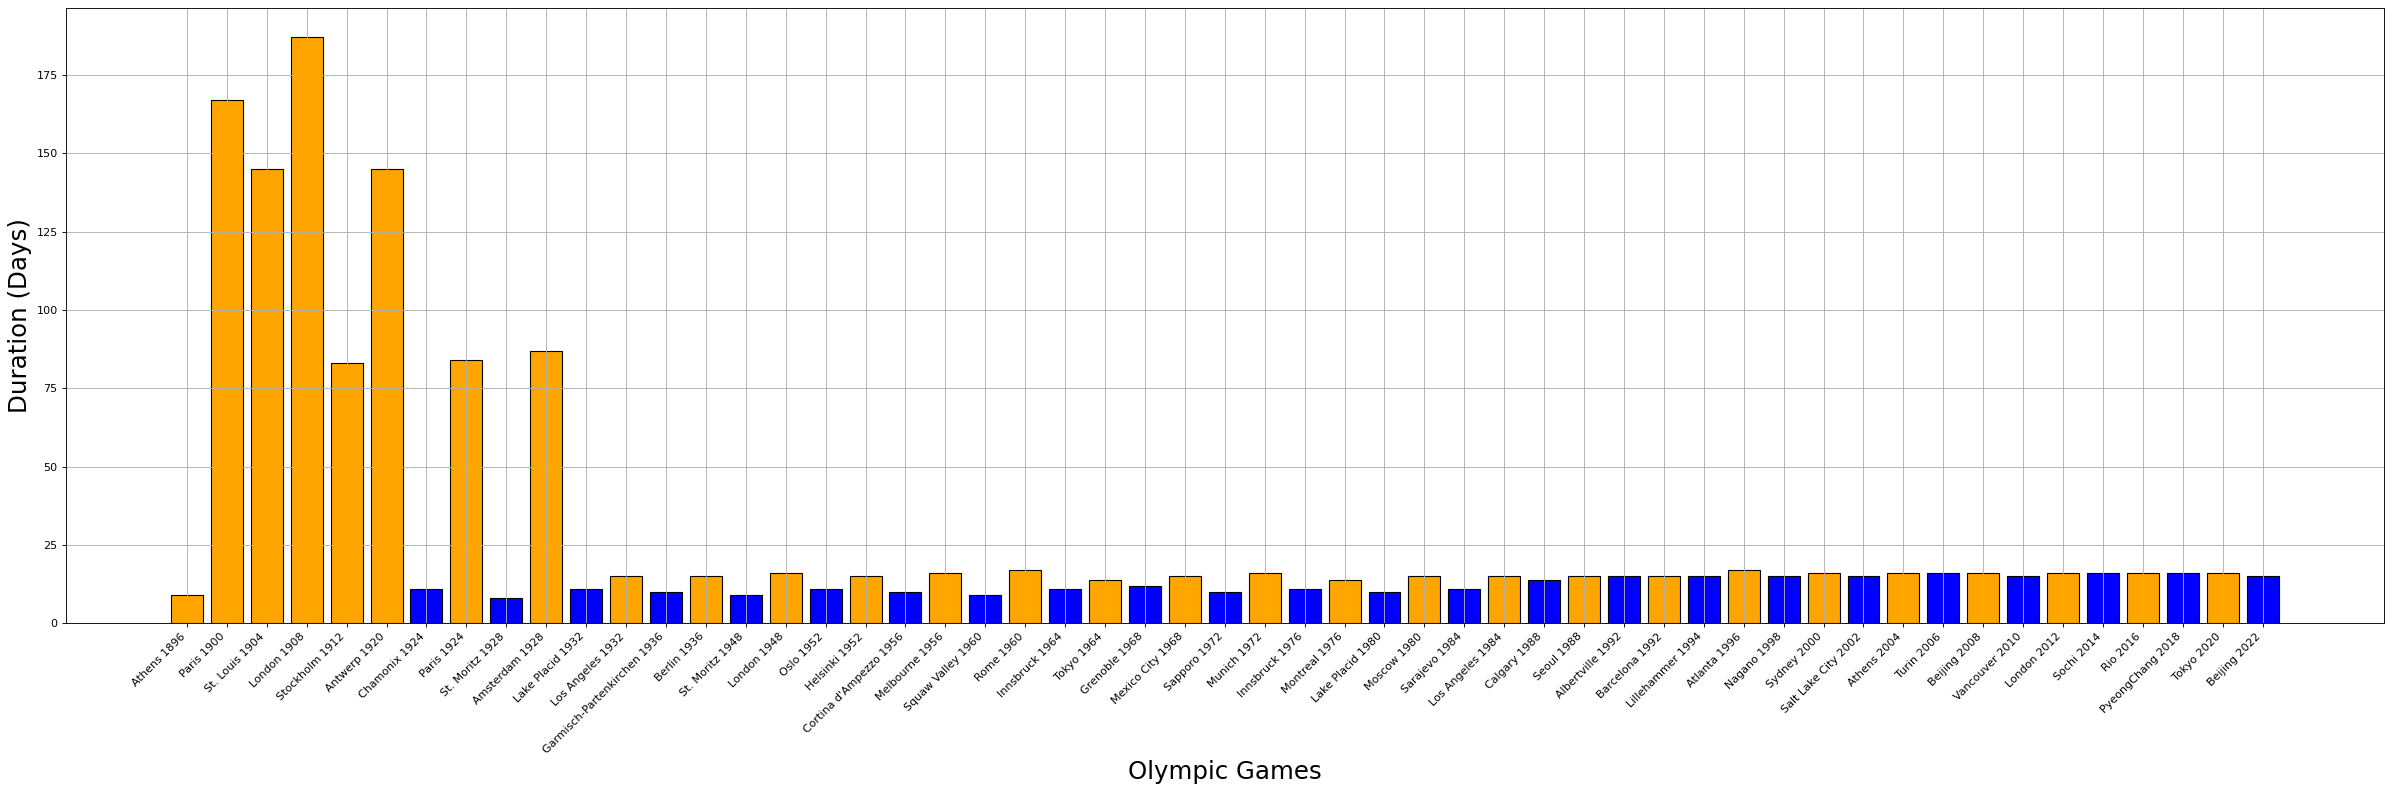

In [ ]:
hosts_data["game_duration_days"] = (
    hosts_data["game_end_date"] - hosts_data["game_start_date"]
).dt.days

hosts_data = hosts_data.sort_values("game_start_date")

hosts_data["game_season_color"] = hosts_data["game_season"].map(
    {"Winter": "blue", "Summer": "orange"}
)

plt.figure(figsize=(30, 10), dpi=80)
plt.bar(
    hosts_data["game_name"],
    hosts_data["game_duration_days"],
    color=hosts_data["game_season_color"],
    edgecolor="black",
)
plt.xlabel("Olympic Games", fontsize=22)
plt.ylabel("Duration (Days)", fontsize=22)
# plt.title("Duration of Olympic Games", fontsize=22)
plt.xticks(rotation=45, ha="right")

plt.grid()
plt.tight_layout()
plt.show()

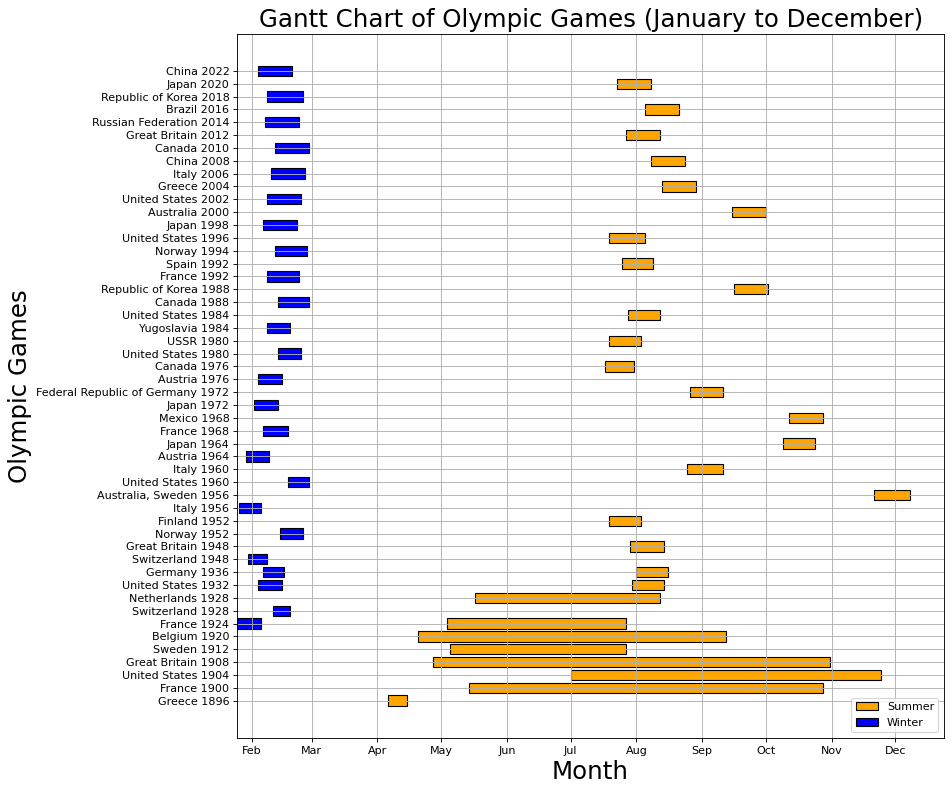

In [ ]:
hosts_data["start_month_day"] = hosts_data["game_start_date"].dt.strftime("%m-%d")
hosts_data["end_month_day"] = hosts_data["game_end_date"].dt.strftime("%m-%d")

hosts_data["start_date"] = pd.to_datetime(hosts_data["start_month_day"], format="%m-%d")
hosts_data["end_date"] = pd.to_datetime(hosts_data["end_month_day"], format="%m-%d")

hosts_data["duration"] = (hosts_data["end_date"] - hosts_data["start_date"]).dt.days

plt.figure(figsize=(12, 10), dpi=80)

bars = []
labels = []
for index, row in hosts_data.iterrows():
    bar = plt.barh(
        y=f"{row["game_location"]} {row["game_year"]}",
        left=row["start_date"],
        width=row["duration"],
        color=row["game_season_color"],
        edgecolor="black",
    )
    if row["game_season"] not in labels:
        bars.append(bar[0])
        labels.append(row["game_season"])

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xlabel("Month", fontsize=22)
plt.ylabel("Olympic Games", fontsize=22)
plt.title("Gantt Chart of Olympic Games (January to December)", fontsize=22)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.legend(bars, labels, loc="lower right")

plt.grid()
plt.tight_layout()
plt.show()

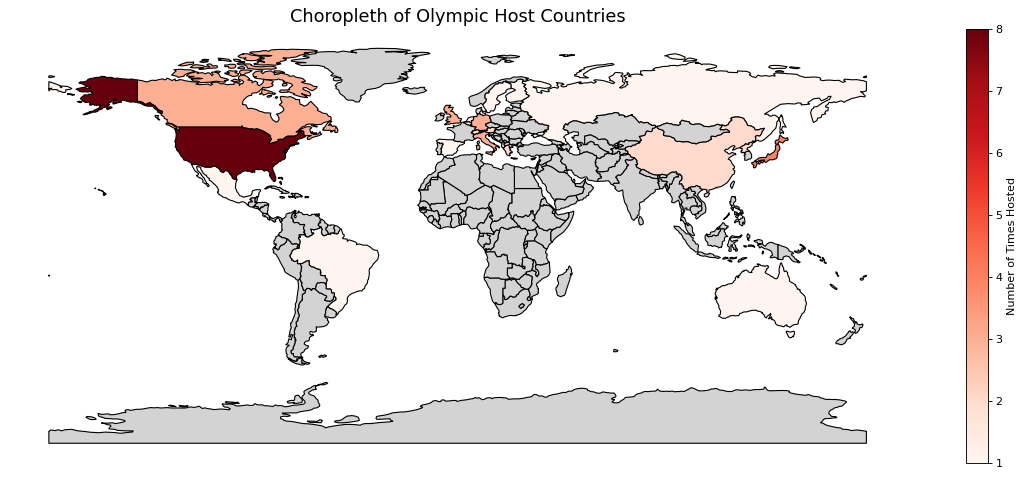

In [ ]:
world = gpd.read_file(os.path.join(DATA_PATH, "map", "ne_110m_admin_0_countries.shp"))

host_counts = hosts_data.groupby("country_code")["game_name"].count().reset_index()
host_counts.columns = ["country_code", "host_count"]

world = world.merge(host_counts, how="left", left_on="ISO_A2", right_on="country_code")

fig, ax = plt.subplots(figsize=(15, 6), dpi=80)

world.plot(
    column="host_count",
    cmap="Reds",
    legend=True,
    legend_kwds={"label": "Number of Times Hosted"},
    edgecolor="black",
    missing_kwds={"color": "lightgrey", "label": "No Data"},
    ax=ax
)

plt.title("Choropleth of Olympic Host Countries", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()

## Results

In [ ]:
results_data.sample(10)

,discipline_title,event_title,slug_game,participant_type,medal_type,athletes,rank_equal,rank_position,country_name,country_code,country_3_letter_code,athlete_url,athlete_full_name,value_unit,value_type
126420,Athletics,5000m men,rome-1960,Athlete,NaN,NaN,NaN,5,Australia,AU,AUS,https://olympics.com/en/athletes/david-power,David POWER,831800,TIME
107426,Sailing,tempest mixed,montreal-1976,GameTeam,NaN,"[('John Garvin HOYT', 'https://olympics.com/en...",NaN,15,Puerto Rico,PR,PUR,NaN,NaN,119.0,POINTS
33671,Speed skating,3000m women,vancouver-2010,Athlete,NaN,NaN,NaN,8,Norway,NO,NOR,https://olympics.com/en/athletes/maren-haugli,Maren HAUGLI,250010,TIME
144861,Boxing,Flyweight men,berlin-1936,Athlete,NaN,NaN,True,16,Australia,AU,AUS,https://olympics.com/en/athletes/harry-charles...,Harry Charles COOPER,NaN,NaN
48673,Table Tennis,Singles women,athens-2004,Athlete,NaN,NaN,True,17,Singapore,SG,SGP,https://olympics.com/en/athletes/jun-hong-jing,Jun Hong JING,NaN,NaN
132257,Cross Country Skiing,30km mass start men,cortina-d-ampezzo-1956,Athlete,NaN,NaN,NaN,5,Soviet Union,NaN,URS,https://olympics.com/en/athletes/vladimir-kouzine,Vladimir KOUZINE,6369000,TIME
1504,Biathlon,Men's 10km Sprint,beijing-2022,Athlete,NaN,NaN,False,63,Bulgaria,BG,BUL,https://olympics.com/en/athletes/gerdzhikov,Dimitar GERDZHIKOV,26:56.5,TIME
61374,Athletics,javelin throw women,sydney-2000,Athlete,SILVER,NaN,NaN,2,Greece,GR,GRE,https://olympics.com/en/athletes/mirella-mania...,Mirella MANIANI-TZELILI,NaN,NaN
132614,Alpine Skiing,giant slalom women,cortina-d-ampezzo-1956,Athlete,NaN,NaN,NaN,10,France,FR,FRA,https://olympics.com/en/athletes/josette-neviere,Josette NEVIERE,120800,TIME
56339,Cross Country Skiing,15km mass start women,salt-lake-city-2002,Athlete,NaN,NaN,NaN,5,Belarus,BY,BLR,https://olympics.com/en/athletes/svetlana-nage...,Svetlana NAGEJKINA,2417900,TIME


In [ ]:
results_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162804 entries, 0 to 162803
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   discipline_title       162804 non-null  object
 1   event_title            162804 non-null  object
 2   slug_game              162804 non-null  object
 3   participant_type       162804 non-null  object
 4   medal_type             20206 non-null   object
 5   athletes               7976 non-null    object
 6   rank_equal             32526 non-null   object
 7   rank_position          158926 non-null  object
 8   country_name           162804 non-null  object
 9   country_code           157768 non-null  object
 10  country_3_letter_code  162804 non-null  object
 11  athlete_url            129991 non-null  object
 12  athlete_full_name      141646 non-null  object
 13  value_unit             78646 non-null   object
 14  value_type             90049 non-null   object
dtype

We noticed that some athletes in this dataset lack corresponding metadata in `athletes_data`.

In [ ]:
athlete_urls_set = set(athletes_data["athlete_url"].dropna())
results_urls_set = set(results_data["athlete_url"].dropna())

missing_urls = list(results_urls_set - athlete_urls_set)

print(f"There are {len(missing_urls)} medalists without metadata")

There are 559 medalists without metadata


We noticed that not all athletes have an associated URL.

In [ ]:
np.sum(~results_data["athlete_full_name"].isna()) == np.sum(~results_data["athlete_url"].isna())

False

In [ ]:
print(
    f"Athletes without URL: {np.sum(~results_data["athlete_full_name"].isna() & results_data["athlete_url"].isna())}"
)

Athletes without URL: 11655


In [ ]:
results_data = results_data.reset_index(drop=True)

In [ ]:
results_data.to_csv(os.path.join(CLEAN_DATA_PATH, "olympic_results.csv"), index=False)